In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from Bio import Entrez
import plotnine as plt9
import requests
import json
import pandas as pd

Entrez.email = 'oa3@sanger.ac.uk'

In [2]:
all_loci = pd.read_excel('data/LocusFocusMasterSpreadsheet.xlsx', skiprows=8)
gene_list = pd.read_csv('data/gene_coordinates.GRCh37.ensembl_v91.txt', sep='\t',names=['ENS', 'CHR', 'START', 'END', 'STRAND', 'NAME'])
tobi_loci = all_loci[all_loci.Assigned=='Tobi'].copy()
tobi_loci

,Assigned,Chr,topSNP Position (bp),topSNP rsid,LD_left,LD_right,Number of previously reported GW significant variants in locus,topSNP P value,Study where the topSNP was reported with the smallest Pvalue (PMID),Trait,PMeta for trait,PHet for trait,PMeta value for CD,PHet value for CD,PMeta value for UC,PHet value for UC,PMeta value for IBD,PHet value for IBD,Genes in locus,Implicated gene
226,Tobi,20,44742064,rs1569723,44680853,44749251,3,1.000000e-13,23128233,IBD,1.984e-06,0.1953,1.577000e-07,0.05477,5.815000e-02,0.4412,1.984000e-06,0.19530,"CD40,SLC12A5,NCOA5",NaN
227,Tobi,20,48955424,rs913678,48955424,48968438,1,5.350000e-11,26192919,IBD,4.211e-07,0.4114,5.306000e-03,0.60040,1.002000e-05,0.5990,4.211000e-07,0.41140,.,NaN
228,Tobi,20,57824309,rs259964,57809343,57829821,1,1.000000e-12,23128233,IBD,3.371e-09,0.9362,4.148000e-07,0.96850,2.876000e-04,0.4791,3.371000e-09,0.93620,ZNF831,NaN
229,Tobi,20,62329099,rs6062496,62270637,62378954,5,6.760000e-26,FM,IBD,2.826e-26,0.0746,2.615000e-13,0.41840,8.966000e-17,0.3220,2.826000e-26,0.07460,"TNFRSF6B,ARFRP1,LIME1,RP4-583P15.14,STMN3,RTEL...",NaN
230,Tobi,21,16817938,rs2823286,16781136,16841303,6,9.000000e-30,23128233,IBD,4.431e-29,0.07274,5.990000e-26,0.21890,1.591000e-13,0.2520,4.431000e-29,0.07274,.,NaN
231,Tobi,21,34776695,rs2284553,34752334,34777409,2,5.630000e-17,26192919,CD,1.14e-14,0.6235,1.140000e-14,0.62350,1.208000e-01,0.2958,7.401000e-09,0.31580,IFNGR2,NaN
232,Tobi,21,40465534,rs2836878,40458508,40468838,2,5.000000e-48,23128233,IBD,2.298e-29,0.09278,3.896000e-07,0.15790,1.834000e-32,0.6618,2.298000e-29,0.09278,.,NaN
233,Tobi,21,45615741,rs7282490,45611686,45634148,4,9.850000e-30,26192919,IBD,1.853e-23,0.214,1.896000e-18,0.28710,5.331000e-13,0.2295,1.853000e-23,0.21400,.,NaN
234,Tobi,22,21922904,rs2266959,21910280,21998833,4,1.000000e-16,23128233,IBD,4.124e-15,0.6418,1.436000e-15,0.94110,9.483000e-06,0.5448,4.124000e-15,0.64180,"YDJC,SDF2L1,UBE2L3,CCDC116",NaN
235,Tobi,22,30493882,rs5763767,30130115,30592487,5,8.820000e-15,26192919,IBD,4.168e-08,0.1089,7.909000e-07,0.06702,3.211000e-04,0.8278,4.168000e-08,0.10890,"UQCR10,ASCC2,ZMAT5,HORMAD2,MTMR3",NaN


In [3]:
tobi_loci_num_genes = tobi_loci['Genes in locus'].str.split(',').apply(len) # counts 0 genes as 1 because of . character

many_genes = tobi_loci[tobi_loci_num_genes > 3]
some_genes = tobi_loci[(tobi_loci_num_genes <= 3) & (tobi_loci['Genes in locus'] != '.')]
no_genes = tobi_loci[tobi_loci['Genes in locus'] == '.']

# Handing the many genes

In [4]:
many_genes['Genes in locus']

229    TNFRSF6B,ARFRP1,LIME1,RP4-583P15.14,STMN3,RTEL...
234                           YDJC,SDF2L1,UBE2L3,CCDC116
235                     UQCR10,ASCC2,ZMAT5,HORMAD2,MTMR3
239    DNAJB7,AL035681.1,TOB2,ST13,RBX1,L3MBTL2,CHADL...
Name: Genes in locus, dtype: object

### Literature search
First I will try doing a literature search for key terms together with each gene.

I will do this in a somewhat statistical fashion by seeing the distribution of counts for every gene that exists, in combination with each word. Then I will normalise that count by the number of hits the gene on its own gets.
Finally I will only consider the top 5% of normalised count scores to be associated with that term.

But first I will check the distribution for each term. Ideally they will be bimodal and I won't have to look at the top 5% at all.

In [5]:
# def query_maker(words, gene):
#     '''
#     Makes a pubmed query from the input words and a given gene.
#     Input: Words (list of string), Gene (string)
#     Output: Query (string)
#     '''
#     orred_words = ') OR ('.join(words)
#     orred_words = '((' + orred_words + '))'
    
#     query = orred_words + ' AND {}'.format(gene)
    
#     return(query)

# # test it works
# print(query_maker(['test', 'words', 'example'], 'GENE-ABC'))
    

In [6]:
def search_pubmed(query):
    '''
    Searches pubmed with a provided query
    '''
    handle = Entrez.esearch(db="pubmed", term=query)
    record = Entrez.read(handle)
    handle.close()
    return(record)

# Test example
# search_pubmed(query_maker(['IBD', 'Crohn\'s', 'immune'], 'NOD2'))

In [7]:
# def find_pubmed_hits(catted_genes_string):
#     '''
#     Function that is applied to the 'Genes in locus' column in the dataframe
#     '''
    
#     # Hardcoded for now, may make them input later
#     keywords = ['IBD', 'inflammation', 'inflammatory bowel disease', 'Crohn\'s',
#             'Ulcerative colitis', 'immune', 'gut', 'bowel']
    
#     genes = catted_genes_string.split(',')
#     # For each gene, find out how maby pubmed hits it has when searched in combination with one of the various keywords
#     genes_hits_list = ['{} : {}'.format(gene,search_pubmed(query_maker(keywords, gene))['Count']) for gene in genes]
#     genes_hits = ', '.join(genes_hits_list)
#     return(genes_hits)

# # Testing it works
# find_pubmed_hits('TNFRSF6B,ARFRP1,LIME1,RP4-583P15.14')

In [8]:
# controls = 'NOD2,TTN'

# print(find_pubmed_hits(controls))
# print('Many genes')
# pub_results = many_genes['Genes in locus'].apply(find_pubmed_hits)
# for result in pub_results:
#     print(result)
# print('Some genes')
# pub_results = some_genes['Genes in locus'].apply(find_pubmed_hits)
# for result in pub_results:
#     print(result)

In [9]:
print(gene_list['NAME'][1:200])

def phrase_gene_distributions(phrase_list, gene_list):
    '''
    For a given phrase list and gene list, finds all possible
    '''
    gene_counts_df = pd.DataFrame (gene_list,columns=['Gene'])
    gene_counts_df.set_index('Gene', inplace=True)
    for phrase in phrase_list:
        print(phrase)
        for gene in gene_list:
            try:
                gene_counts_df.at[gene, phrase] = int(search_pubmed('{} AND {}"'.format(phrase, gene))['Count'])
            except:
                print('Could not search for {}'.format(gene))
    
    return gene_counts_df


keywords = ['IBD', 'inflammation', 'inflammatory bowel disease', 'Crohn\'s',
            'Ulcerative colitis', 'immune', 'gut', 'bowel', '']
gene_distributions = phrase_gene_distributions(['IBD'], ['MXRA8'])

# gene_distributions.to_csv('gene_phrase_distributions.csv')

1      AL627309.1
2          OR4F29
3          OR4F16
4      AL669831.1
5      AL645608.2
          ...    
195      PRAMEF14
196      PRAMEF19
197      PRAMEF17
198      PRAMEF20
199        LRRC38
Name: NAME, Length: 199, dtype: object
IBD


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 416.0, 4.0, 0.0, 0.0, 0.0, 230.0, 425.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 6.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 3.0, 0.0, 0.0, 4.0, 5.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 0.0, 52.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 103.0, 0.0, 3.0, 1.0, 0.0, 11.0, 0.0, 1.0, 1.0, 1.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 18.0, 0.0, 6.0, 3.0, 0.0, 3.0, 0.0, 0.0, 51.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 16.0, 20.0, 4.0, 171.0, 17.0, 3.0, 0.0, 1.0, 46.0, 8.0, 1.0, 5.0, 0.0, 1.0, 3.0, 0.0, 0.0, 94.0, 0.0, 0.0, 3.0, 0.0, 2.0, 5.0, 1.0, 7.0, 126.0, 1.0, 0.0, 277.0, 2.0, 3.0, 0.0, 0.0, 6.0, 85.0, 140.0, 4.0, 2018.0, 1.0, 1.0, 0.0, 1.0, 0.0, 3.0, 2.0, 0.0, 4.0, 0.0, 58.0, 1.0, 11.0, 12.0, 0.0, 2.0, 21.0, 0.0, 13.0, 64.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,

(array([106.,  29.,  11., ...,   0.,   0.,   1.]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.016e+03, 2.017e+03,
        2.018e+03]),
 <BarContainer object of 2018 artists>)

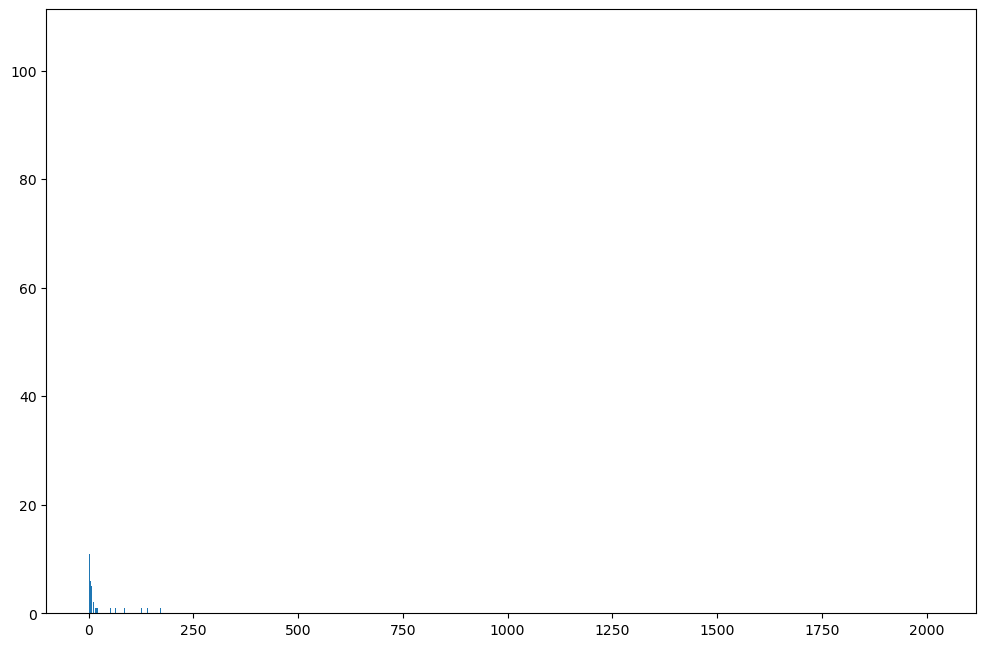

In [67]:
print(list(gene_distributions.loc[:,'immune']))

plot_data = gene_distributions.loc[:,'immune']

plt.hist(plot_data,bins=int(np.max(plot_data)))

### Using opentargets API to automatically assign genes to loci

In [2]:
query = """{
  v_11_59864062_C_T: genesForVariant(variantId: "11_59864062_C_T") {
    overallScore
    gene {
      id
      symbol
      chromosome
      start
      end
      tss
    }
    qtls {
      aggregatedScore
      typeId
      sourceId
      tissues {
        tissue {
          id
          name
        }
        quantile
        beta
        pval
      }
    }
  }
}"""



In [3]:
url = 'http::genetics-api.opentargets.io/graphql'
r = requests.post(url, json={'query': query})
print(r.status_code)
print(r.text)

MissingSchema: Invalid URL 'genetics-api.opentargets.io/graphql': No schema supplied. Perhaps you meant http://genetics-api.opentargets.io/graphql?

# Handling the gene deserts

### How large are the loci with no genes?

In [116]:
print(no_genes.LD_right - no_genes.LD_left)
print(many_genes.LD_right - many_genes.LD_left)

227    13014
230    60167
232    10330
233    22462
dtype: int64
229     108317
234      88553
235     462372
239    1000654
dtype: int64
